In [ ]:
# Ensemble Loaded

In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt

# Set directory paths
current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/merged_dataset/Train")
test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/merged_dataset/Test")

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# def binarize_image(image):
#     _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
#     return binary_image

# # Create ImageDataGenerator objects with the custom preprocessing function
# train_datagen = ImageDataGenerator(
#     preprocessing_function=binarize_image,
#     rotation_range=60,
#     width_shift_range=0.3,
#     height_shift_range=0.3,
#     shear_range=0.3,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# test_datagen = ImageDataGenerator(preprocessing_function=binarize_image)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(200, 200),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(200, 200),
                                                  batch_size=32,
                                                  class_mode='binary')

Found 5558 images belonging to 2 classes.
Found 2010 images belonging to 2 classes.


In [1]:

# Define Custom CNN Model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()

        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')

        self.flatten = tf.keras.layers.Flatten()

        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate and compile Custom CNN Model
custom_cnn_model = MyModel()
custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Custom CNN Model
custom_cnn_history = custom_cnn_model.fit(train_generator,
                                          steps_per_epoch=train_generator.samples // train_generator.batch_size,
                                          epochs=1,
                                          validation_data=test_generator,
                                          validation_steps=test_generator.samples // test_generator.batch_size,
                                          verbose=2)

# Define VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
for layer in base_model.layers:
    layer.trainable = False

# Build VGG16-based model
vgg_model = models.Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(512, activation='relu'))
vgg_model.add(layers.Dense(1, activation='sigmoid'))
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train VGG16-based Model
vgg_history = vgg_model.fit(train_generator,
                            steps_per_epoch=train_generator.samples // train_generator.batch_size,
                            epochs=1,
                            validation_data=test_generator,
                            validation_steps=test_generator.samples // test_generator.batch_size,
                            verbose=2)

# Obtain predictions from both models
custom_cnn_predictions = custom_cnn_model.predict(test_generator)
vgg_predictions = vgg_model.predict(test_generator)

# Combine predictions using averaging
ensemble_predictions = (custom_cnn_predictions + vgg_predictions) / 2

# Evaluate ensemble predictions
ensemble_loss, ensemble_accuracy = vgg_model.evaluate(test_generator, verbose=2)
print("Ensemble Model Accuracy:", ensemble_accuracy)


2024-03-31 11:44:22.559255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-31 11:44:22.559457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 5558 images belonging to 2 classes.
Found 2010 images belonging to 2 classes.


2024-03-31 11:44:26.867376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 11:44:26.867535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/abhi/MP/.env/lib/python3.9/site-packages/cv2/../../lib64:
2024-03-31 11:44:26.867612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/abhi/MP/.env/lib/python3.9/site-packages/cv2/../../lib64:
2024-03-31 11:44:26.867690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: li

173/173 - 790s - loss: 2.6666 - accuracy: 0.5250 - val_loss: 0.6911 - val_accuracy: 0.5323 - 790s/epoch - 5s/step
173/173 - 1078s - loss: 0.7922 - accuracy: 0.6390 - val_loss: 0.5611 - val_accuracy: 0.7026 - 1078s/epoch - 6s/step
63/63 - 268s - loss: 0.5603 - accuracy: 0.7030 - 268s/epoch - 4s/step
Ensemble Model Accuracy: 0.7029850482940674


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(custom_cnn_history.history['accuracy'], label='Custom CNN Training Accuracy')
plt.plot(custom_cnn_history.history['val_accuracy'], label='Custom CNN Validation Accuracy')
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(custom_cnn_history.history['loss'], label='Custom CNN Training Loss')
plt.plot(custom_cnn_history.history['val_loss'], label='Custom CNN Validation Loss')
plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.plot(vgg_history.history['val_loss'], label='VGG16 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot ensemble model accuracy and loss
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('Ensemble Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.plot(vgg_history.history['val_loss'], label='VGG16 Validation Loss')
plt.title('Ensemble Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(custom_cnn_history.history['accuracy'], label='Custom CNN Training Accuracy')
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss
plt.plot(custom_cnn_history.history['loss'], label='Custom CNN Training Loss')
plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot ensemble model accuracy
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.title('Ensemble Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot ensemble model loss
plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.title('Ensemble Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
# Define file paths for saving the model weights
custom_cnn_weights_path = os.path.join("/home/abhi/MP/saved_model/vgg/", "custom_cnn_model_weights1.h5")
vgg_weights_path = os.path.join("/home/abhi/MP/saved_model/vgg/", "vgg_model_weights1.h5")

# Save the weights of the custom CNN model
custom_cnn_model.save_weights(custom_cnn_weights_path)

# Save the weights of the VGG16 model
vgg_model.save_weights(vgg_weights_path)

print("Model weights saved successfully!")


Model weights saved successfully!


In [2]:
custom_cnn_weights_path = "/home/abhi/MP/saved_model/cnn.h5"

In [3]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()

        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')

        self.flatten = tf.keras.layers.Flatten()

        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate and compile Custom CNN Model
custom_cnn_model = MyModel()
custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-04-01 01:45:30.217287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 01:45:30.220861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/abhi/MP/.env/lib/python3.9/site-packages/cv2/../../lib64:
2024-04-01 01:45:30.221322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/abhi/MP/.env/lib/python3.9/site-packages/cv2/../../lib64:
2024-04-01 01:45:30.221542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: li

In [4]:
# Instantiate the subclassed model
custom_cnn_model_loaded = MyModel()

# Call the model to initialize its variables
_ = custom_cnn_model_loaded(np.zeros((1, 200, 200, 3), dtype=np.float32))

# Load weights into the model
custom_cnn_model_loaded.load_weights(custom_cnn_weights_path)


2024-04-01 01:45:35.654970: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.
2024-04-01 01:45:37.003082: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.
2024-04-01 01:45:38.351147: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.
2024-04-01 01:45:50.064973: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.


In [5]:
from keras.models import load_model

In [6]:
# cnn_model = load_model('/home/aman/Personal/majorproject/cnn1.h5')
vgg_model_loaded = load_model('/home/abhi/MP/saved_model/VGG16_merged_model_new.h5')

In [19]:
# Obtain predictions from both models
custom_cnn_predictions = custom_cnn_model_loaded.predict(test_generator)
vgg_predictions = vgg_model_loaded.predict(test_generator)

# Combine predictions using averaging
ensemble_predictions = (custom_cnn_predictions + vgg_predictions) / 2



In [7]:
# Define the ensemble model architecture
class EnsembleModel(tf.keras.Model):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def call(self, inputs):
        output1 = self.model1(inputs)
        output2 = self.model2(inputs)
        return (output1 + output2) / 2

# Instantiate the ensemble model
ensemble_model = EnsembleModel(custom_cnn_model_loaded, vgg_model_loaded)

# Compile the ensemble model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [22]:
custom_cnn_model_loaded.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


test_loss, test_acc = custom_cnn_model_loaded.evaluate(test_generator)
print(f'CNN Model Accuracy Merged: {test_acc*100}')

63/63 [==============================] - 53s 795ms/step - loss: 0.4294 - accuracy: 0.7920
CNN Model Accuracy Merged: 79.20398116111755


In [23]:
vgg_test_loss, vgg_test_acc = vgg_model_loaded.evaluate(test_generator)
print(f'VGG Model Accuracy Merged: {vgg_test_acc*100}')

63/63 [==============================] - 512s 8s/step - loss: 0.4115 - accuracy: 0.8095
VGG Model Accuracy Merged: 80.94527125358582


In [24]:
# Evaluate ensemble predictions
ensemble_loss, ensemble_accuracy = ensemble_model.evaluate(test_generator)
print("Ensemble Model Accuracy Merged:", ensemble_accuracy)

63/63 [==============================] - 634s 10s/step - loss: 0.3819 - accuracy: 0.8627
Ensemble Model Accuracy Merged: 0.8626865744590759


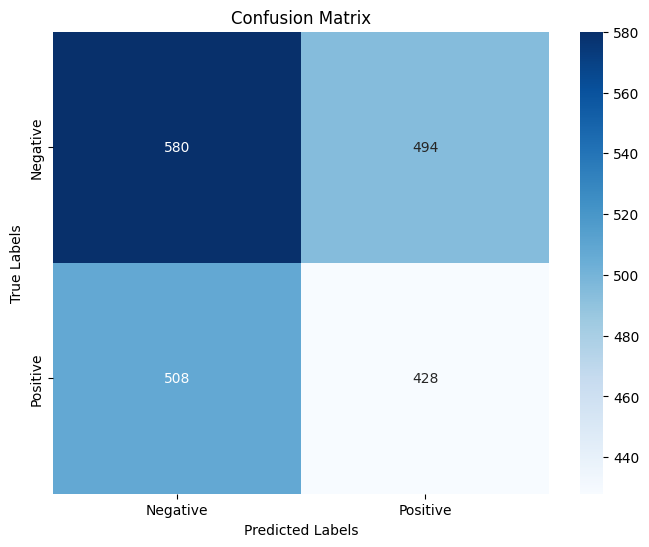

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtain true labels for the test data
true_labels = test_generator.classes

# Convert probabilities to class labels (assuming binary classification)
predicted_labels = (ensemble_predictions > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels)
print("F1-Score:", f1)


Accuracy: 0.5014925373134328
Precision: 0.4642082429501085
Recall: 0.45726495726495725
F1-Score: 0.4607104413347686


In [1]:
import matplotlib.pyplot as plt

# Training history for CNN
cnn_history = {
    "accuracy": [0.5206, 0.5794, 0.6334, 0.6922, 0.7148, 0.7401, 0.7429, 0.7463, 0.7584, 0.7495, 0.7524, 0.7568, 0.7693, 0.7606, 0.7740, 0.7667, 0.7657, 0.7669, 0.7673, 0.7789, 0.7742, 0.7771, 0.7819, 0.7781, 0.7801, 0.7852, 0.7861, 0.7816, 0.7805, 0.7850, 0.7877, 0.7895, 0.7879, 0.7792, 0.7845, 0.7870, 0.7886, 0.7915, 0.7933, 0.7921, 0.7968, 0.7910, 0.7847, 0.7952, 0.7948, 0.7926, 0.7923, 0.7942],
    "loss": [2.2088, 0.6826, 0.6427, 0.5703, 0.5430, 0.5138, 0.5076, 0.5019, 0.4912, 0.4901, 0.4917, 0.4865, 0.4746, 0.4776, 0.4657, 0.4670, 0.4652, 0.4618, 0.4653, 0.4519, 0.4634, 0.4539, 0.4468, 0.4545, 0.4482, 0.4538, 0.4495, 0.4527, 0.4525, 0.4504, 0.4402, 0.4322, 0.4385, 0.4401, 0.4461, 0.4392, 0.4359, 0.4378, 0.4366, 0.4281, 0.4314, 0.4279, 0.4295, 0.4438, 0.4320, 0.4289, 0.4240, 0.4309, 0.4277]
}

# Training history for VGG-16
vgg_history = {
    "accuracy": [0.6179, 0.7039, 0.7486, 0.7619, 0.7743, 0.7739, 0.7758, 0.7796, 0.7872, 0.7814, 0.7958, 0.8072, 0.8014, 0.7952, 0.8001, 0.8034, 0.8063, 0.8185, 0.8156, 0.8147, 0.8247, 0.8214, 0.8167, 0.8182, 0.8149, 0.8329, 0.8406, 0.8407, 0.8436, 0.8322, 0.8398, 0.8369, 0.8344, 0.8420, 0.8456, 0.8455, 0.8518, 0.8307, 0.8391, 0.8571, 0.8495, 0.8549, 0.8569, 0.8598, 0.8578, 0.8608, 0.8493, 0.8575, 0.8680, 0.8611],
    "loss": [0.8546, 0.5753, 0.5116, 0.4913, 0.4786, 0.4763, 0.4707, 0.4623, 0.4504, 0.4533, 0.4347, 0.4183, 0.4287, 0.4457, 0.426, 0.4225, 0.4059, 0.3965, 0.3955, 0.3976, 0.3849, 0.3825, 0.3896, 0.3898, 0.3922, 0.3607, 0.3518, 0.3507, 0.3485, 0.3677, 0.3505, 0.3591, 0.3644, 0.3522, 0.3472, 0.3462, 0.3348, 0.3738, 0.3521, 0.3198, 0.3297, 0.3224, 0.3183, 0.3114, 0.3131, 0.3175, 0.3318, 0.3087, 0.2963, 0.3075]
}

# Ensemble history (average of CNN and VGG-16)
ensemble_history = {
    "accuracy": [(cnn_acc + vgg_acc) / 2 for cnn_acc, vgg_acc in zip(cnn_history["accuracy"], vgg_history["accuracy"])],
    "loss": [(cnn_loss + vgg_loss) / 2 for cnn_loss, vgg_loss in zip(cnn_history["loss"], vgg_history["loss"])]
}

# # Plotting
# epochs = range(1, len(cnn_history["accuracy"]) + 1)

# # Plotting CNN accuracy and loss
# plt.figure(figsize=(14, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, cnn_history["accuracy"], 'b', label='CNN Training acc')
# plt.title('CNN Training accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs, cnn_history["loss"], 'b', label='CNN Training loss')
# plt.title('CNN Training loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plotting VGG-16 accuracy and loss
# plt.figure(figsize=(14, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, vgg_history["accuracy"], 'r', label='VGG-16 Training acc')
# plt.title('VGG-16 Training accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs, vgg_history["loss"], 'r', label='VGG-16 Training loss')
# plt.title('VGG-16 Training loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plotting Ensemble accuracy and loss
# plt.figure(figsize=(14, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, ensemble_history["accuracy"], 'g', label='Ensemble Training acc')
# plt.title('Ensemble Training accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs, ensemble_history["loss"], 'g', label='Ensemble Training loss')
# plt.title('Ensemble Training loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [2]:
import csv

# Writing CNN history to a CSV file
with open('cnn_history.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Accuracy', 'Loss'])
    writer.writerows(zip(cnn_history['accuracy'], cnn_history['loss']))

# Writing VGG history to a CSV file
with open('vgg_history.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Accuracy', 'Loss'])
    writer.writerows(zip(vgg_history['accuracy'], vgg_history['loss']))

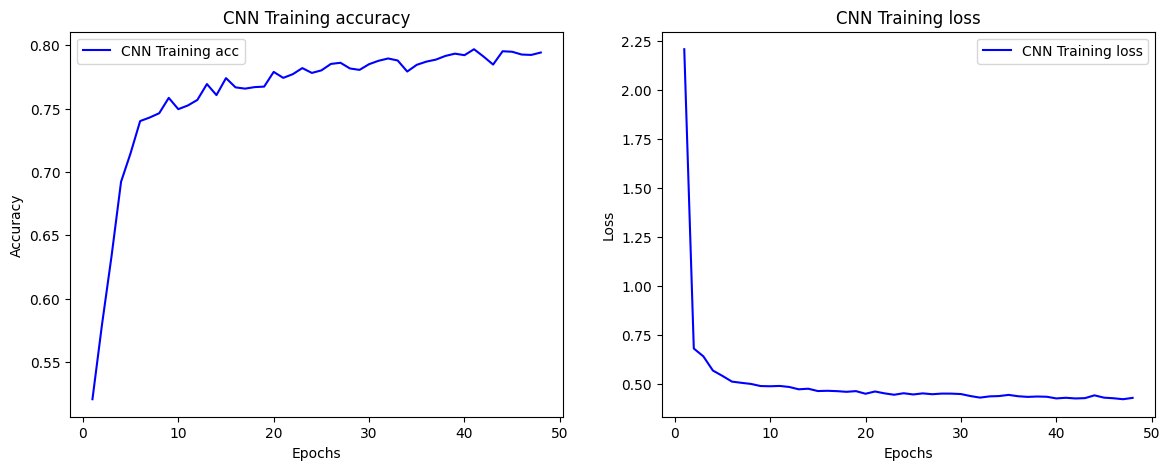

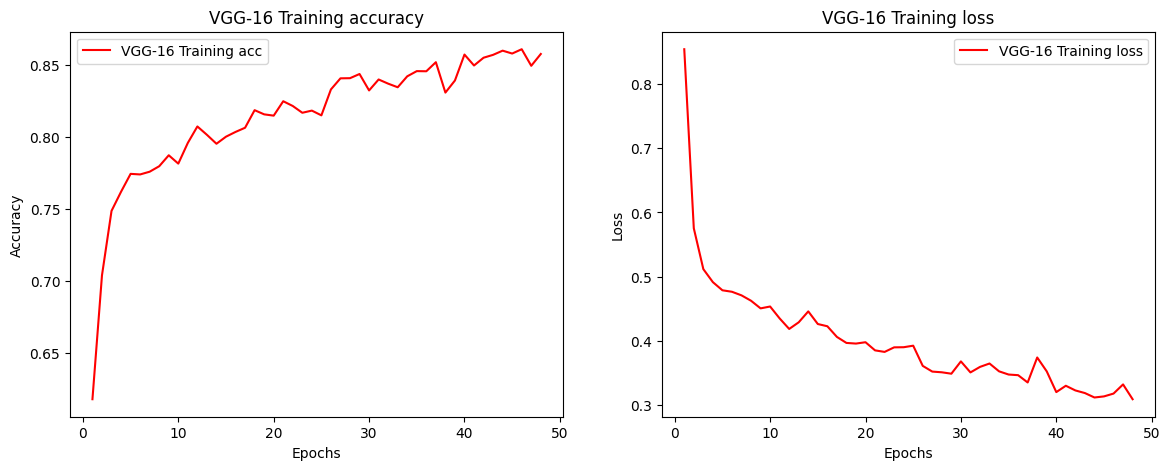

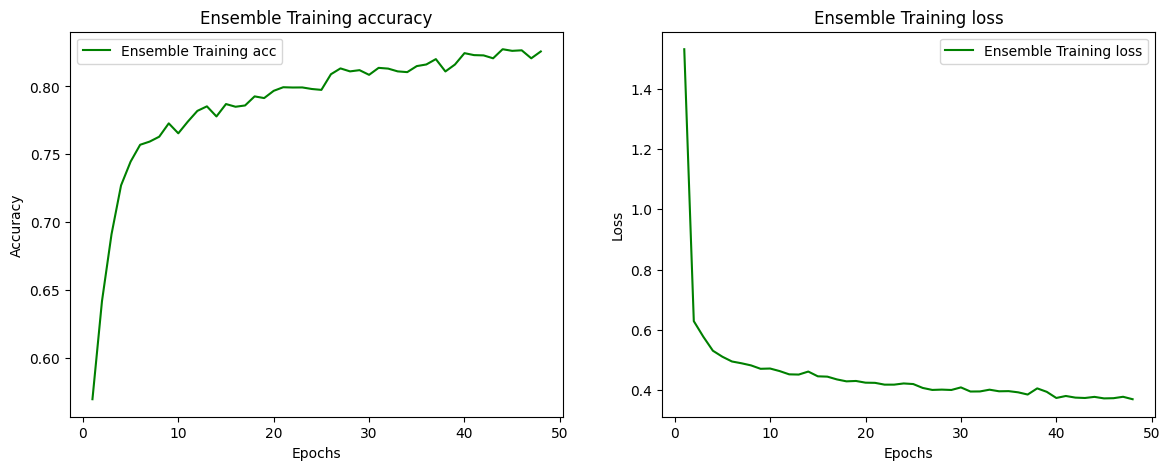

In [63]:
import matplotlib.pyplot as plt

# Truncate histories to the length of the shortest one
min_length = min(len(cnn_history["accuracy"]), len(vgg_history["accuracy"]), len(ensemble_history["accuracy"]))
cnn_history = {key: value[:min_length] for key, value in cnn_history.items()}
vgg_history = {key: value[:min_length] for key, value in vgg_history.items()}
ensemble_history = {key: value[:min_length] for key, value in ensemble_history.items()}

# Plotting
epochs = range(1, min_length + 1)

# Plotting CNN accuracy and loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, cnn_history["accuracy"], 'b', label='CNN Training acc')
plt.title('CNN Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, cnn_history["loss"], 'b', label='CNN Training loss')
plt.title('CNN Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting VGG-16 accuracy and loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, vgg_history["accuracy"], 'r', label='VGG-16 Training acc')
plt.title('VGG-16 Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, vgg_history["loss"], 'r', label='VGG-16 Training loss')
plt.title('VGG-16 Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Ensemble accuracy and loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, ensemble_history["accuracy"], 'g', label='Ensemble Training acc')
plt.title('Ensemble Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, ensemble_history["loss"], 'g', label='Ensemble Training loss')
plt.title('Ensemble Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


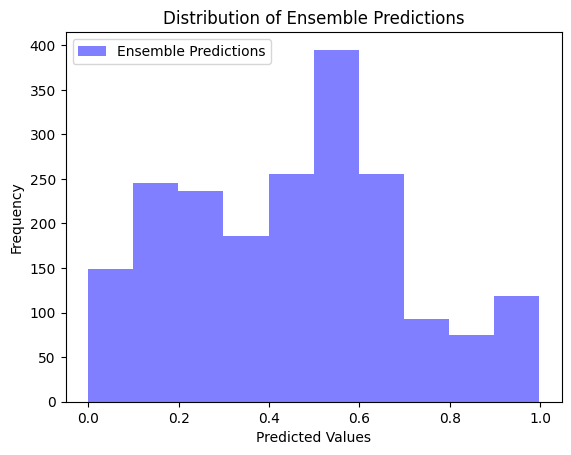

In [52]:
import matplotlib.pyplot as plt

# Plot a histogram of ensemble predictions
plt.hist(ensemble_predictions, bins=10, alpha=0.5, color='blue', label='Ensemble Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Distribution of Ensemble Predictions')
plt.legend()
plt.show()


In [ ]:
# # Define file paths for saved model weights

# vgg_weights_path = "/home/abhi/MP/saved_model/VGG16_merged_model_new.h5"

# # # Define the paths for saved models
# # custom_cnn_model_path = "custom_cnn_model.h5"
# # vgg_model_path = "vgg_model.h5"

# # # Load the models
# # custom_cnn_model_loaded = MyModel()
# # vgg_model_loaded = tf.keras.models.Sequential()

# # Load weights into models
# # custom_cnn_model_loaded.load_weights(custom_cnn_weights_path)
# vgg_model_loaded.load_weights(vgg_weights_path)

# # # Load the architectures of the models
# # # custom_cnn_model_loaded = tf.keras.models.load_model(custom_cnn_model_path)
# # vgg_model_loaded = tf.keras.models.load_model(vgg_model_path)

# # print("Models loaded successfully!")


In [42]:
# custom_cnn_model_loaded.predict(test_generator)

# Compile the custom CNN model
custom_cnn_model_loaded.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the custom CNN model
test_loss, test_acc = custom_cnn_model_loaded.evaluate(test_generator)
print(f'Test Accuracy: {test_acc*100}')


63/63 [==============================] - 39s 607ms/step - loss: 0.4294 - accuracy: 0.7920
Test Accuracy: 79.20398116111755


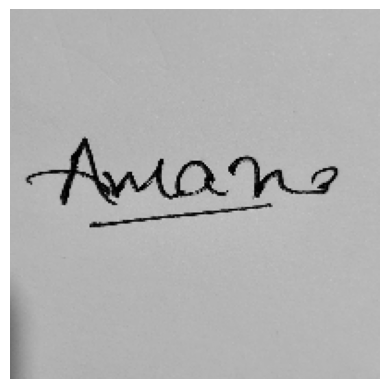

Similarity score: 65.65555334091187%
Invalid Signature


In [25]:
import cv2
import matplotlib.pyplot as plt

image_path = '/home/abhi/MP/3_gray.jpg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (200, 200))
image = image / 255.0  

input_image = image.reshape((1,) + image.shape)

predictions = ensemble_model.predict(input_image)

plt.imshow(image)
plt.axis('off')
plt.show()

print("Similarity score: {}%".format(predictions[0][0]*100))
if predictions >= 0.85:
    print("Valid Signature")
else:
    print("Invalid Signature")

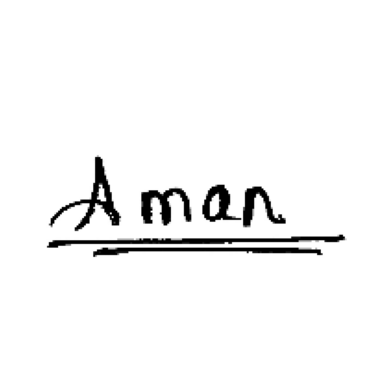

Similarity score: 98.57383966445923%
Valid Signature


In [23]:
import cv2
import matplotlib.pyplot as plt

image_path = '/home/abhi/MP/Binarized_img/aman_real_binarized.jpg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (200, 200))
image = image / 255.0  

input_image = image.reshape((1,) + image.shape)

predictions = ensemble_model.predict(input_image)

plt.imshow(image)
plt.axis('off')
plt.show()

print("Similarity score: {}%".format(predictions[0][0]*100))
if predictions >= 0.85:
    print("Valid Signature")
else:
    print("Invalid Signature")
